## Things to implement:
<ul>
<li>Focal Loss <b>[DONE]</b></li> 
<li>Undersampling of the "O" tags <b>[DONE]</b></li> 
<li><b>[OPTIONAL]</b> SMOTE with Undersampling

# Importing the Libraries

In [1]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import seaborn as sns
import pandas as pd
import numpy as np
# from focal_loss import FocalLoss
# from imblearn.over_sampliong inport SMOTE
# # Note that install both first, then implement
from math import sqrt, log

# Importing the relevant files
train_file = '../../Data/NCBItrainset_corpus.txt'
dev_file = '../../Data/NCBIdevelopset_corpus.txt'
model_name = '../../Models/BiLSTM_CrossAttention_NER_model.pth'
unknown_token = "<UNK>"

# Data Preparation

In [2]:
# Reading and parsing the dataset file
def read_dataset(file_path):
    with open(file_path, "r") as file:
        lines = file.readlines()
    return lines

def parse_dataset(lines):
    paragraphs, paragraph = [], []
    for line in lines:
        line = line.strip()
        if line:
            paragraph.append(line)
        else:
            if paragraph:
                paragraphs.append(paragraph)
                paragraph = []
    if paragraph:
        paragraphs.append(paragraph)
    return paragraphs

In [3]:
def parse_paragraph(paragraph):
    sentences, annotations, sentence = [], [], []
    for line in paragraph:
        if re.match(r'^\d+\|\w\|', line):
            sentence.extend(line.split('|')[2].split())
        elif re.match(r'^\d+\t\d+\t\d+\t', line):
            start, end = int(line.split("\t")[1]), int(line.split("\t")[2])
            annotations.append((start, end, line.split("\t")[3], line.split("\t")[4]))
    if sentence:
        sentences.append(sentence)
    return sentences, annotations

## Tagging the words based on character limits

In [4]:
def tag_annotations(sentences, annotations):
    tagged_sentences = []
    for sentence in sentences:
        tags = ['O'] * len(sentence)
        word_starts, word_ends, char_pos = [], [], 0
        for word in sentence:
            word_starts.append(char_pos)
            char_pos += len(word)
            word_ends.append(char_pos)
            char_pos += 1
        for start, end, _, label in annotations:
            for i, (word_start, word_end) in enumerate(zip(word_starts, word_ends)):
                if word_start >= start and word_end <= end:
                    if label == 'Modifier':
                        tags[i] = 'I-' + 'SpecificDisease'
                    # elif label == '':
                    #     tags[i] = 'I-' + 'SpecificDisease'
                    else:
                        tags[i] = 'I-' + label
                elif word_start < start < word_end or word_start < end < word_end:
                    if label == 'Modifier':
                        tags[i] = 'I-' + 'SpecificDisease'
                    else:
                        tags[i] = 'I-' + label
        tagged_sentences.append((sentence, tags))
    return tagged_sentences

## Preparing Data

In [5]:
# Prepare the training and validation data
# Undersampling the outside tagged data
lines = read_dataset(train_file)
paragraphs = parse_dataset(lines)
all_sentences, all_tags = [], []
for paragraph in paragraphs:
    s, a = parse_paragraph(paragraph)
    tagged_sentences = tag_annotations(s, a)
    for sentence, tag in tagged_sentences:
        all_sentences.append(sentence)
        all_tags.append(tag)
# print (all_sentences)
# print (all_tags)
dev_lines = read_dataset(dev_file)
dev_paragraphs = parse_dataset(dev_lines)
dev_all_sentences, dev_all_tags = [], []
for dev_paragraph in dev_paragraphs:
    dev_s, dev_a = parse_paragraph(dev_paragraph)
    dev_tagged_sentences = tag_annotations(dev_s, dev_a)
    for dev_sentence, dev_tag in dev_tagged_sentences:
        dev_all_sentences.append(dev_sentence)
        dev_all_tags.append(dev_tag)

In [6]:
# EDIT: Modifying the Dataset class to count <UNK> tokens
class LSTM_Attention_NERDataset(Dataset):
    def __init__(self, sentences, tags, word_encoder, tag_encoder, unknown_token='<UNK>'): # undersample_ratio = 0.5
        self.sentences = sentences
        self.tags = tags
        self.word_encoder = word_encoder
        self.tag_encoder = tag_encoder
        self.unknown_token = unknown_token
        self.unk_count = 0
        self.unk_tags = []
        # self.undersample_ratio = undersample_ratio

        # # Undersampling of the "O" tags
        # self.sentences, self.tags = self.undersample()
        
    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        tags = self.tags[idx]
        sentence_encoded = [self.word_encoder.get(word, self.word_encoder[self.unknown_token]) for word in sentence]
        
        # Count <UNK> tokens and collect their tags
        for word, tag in zip(sentence, tags):
            if word not in self.word_encoder:
                self.unk_count += 1
                self.unk_tags.append(tag)
        
        tags_encoded = self.tag_encoder.transform(tags)
        return torch.tensor(sentence_encoded), torch.tensor(tags_encoded, dtype=torch.long)
    
    # def undersample(self):
    #     o_tag_indices = [i for i, tag in enumerate(self.tags) if 'O' in tag]
    #     num_o_tags = len(o_tag_indices)

    #     num_samples = int(num_o_tags * self.undersample_ratio)
    #     sampled_indices = np.random.choice(o_tag_indices, num_samples, replace = False)

    #     # Keeping only sampled data
    #     sentences_sampled = [self.sentences[i] for i in sampled_indices]
    #     tags_sampled = [self.tags[i] for i in sampled_indices]

    #     # Combine the sampled data with the non-O tagged data
    #     non_o_tags = [i for i in range(len(self.sentences)) if i not in o_tag_indices]
    #     sentences_sampled += [self.sentences[i] for i in non_o_tags]
    #     tags_sampled += [self.tags[i] for i in non_o_tags]

    #     sentences_sampled, tags_sampled = shuffle(sentences_sampled, tags_sampled)
    #     return sentences_sampled, tags_sampled

In [7]:
all_words = [word for sentence in all_sentences for word in sentence]
all_tags_flat = [tag for tags in all_tags for tag in tags]

word_encoder = {word: idx for idx, word in enumerate(set(all_words))}
unknown_token = '<UNK>'
word_encoder[unknown_token] = len(word_encoder)

tag_encoder = LabelEncoder()
tag_encoder.fit(all_tags_flat)

dataset = LSTM_Attention_NERDataset(all_sentences, all_tags, word_encoder, tag_encoder, unknown_token,) #, undersample_ratio)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=lambda x: x)

dev_dataset = LSTM_Attention_NERDataset(dev_all_sentences, dev_all_tags, word_encoder, tag_encoder, unknown_token) #, undersample_ratio)
dev_dataloader = DataLoader(dev_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: x)

# Display the counts and tags of <UNK> tokens
print(f"Number of <UNK> tokens in the training dataset: {dataset.unk_count}")
print(f"Tags of <UNK> tokens in the training dataset: {Counter(dataset.unk_tags)}")

print(f"Number of <UNK> tokens in the validation dataset: {dev_dataset.unk_count}")
print(f"Tags of <UNK> tokens in the validation dataset: {Counter(dev_dataset.unk_tags)}")

Number of <UNK> tokens in the training dataset: 0
Tags of <UNK> tokens in the training dataset: Counter()
Number of <UNK> tokens in the validation dataset: 0
Tags of <UNK> tokens in the validation dataset: Counter()


# Cross Attention Class Definition

In [8]:
class CrossAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(CrossAttention, self).__init__()
        self.query = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.key = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, query, key, value):
        query_proj = self.query(query)
        key_proj = self.key(key)
        value_proj = self.value(value)
        attention_scores = torch.matmul(query_proj, key_proj.transpose(-2, -1))
        attention_weights = self.softmax(attention_scores)
        context = torch.matmul(attention_weights, value_proj)
        return context

In [9]:
class BiLSTM_CrossAttention_NER_Model(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=128, hidden_dim=128, dropout_prob=0.35):
        super(BiLSTM_CrossAttention_NER_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.batch_norm_emb = nn.BatchNorm1d(embedding_dim)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True, dropout=dropout_prob)
        self.cross_attention = CrossAttention(hidden_dim * 2)
        self.batch_norm_att = nn.BatchNorm1d(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim * 2, tagset_size)

    def forward(self, x):
        emb = self.embedding(x)
        emb = self.batch_norm_emb(emb.transpose(1, 2)).transpose(1, 2)
        emb = self.dropout(emb)
        
        bilstm_out, _ = self.bilstm(emb)
        bilstm_out = self.dropout(bilstm_out)
        
        cross_att_out = self.cross_attention(bilstm_out, bilstm_out, bilstm_out)
        cross_att_out = self.batch_norm_att(cross_att_out.transpose(1, 2)).transpose(1, 2)
        cross_att_out = self.dropout(cross_att_out)
        
        tag_space = self.fc(cross_att_out)
        return tag_space

### Defining the Focal Class (to be used in the case of highly imbalanced datasets of around 1:1000)

In [10]:
class Focal_Loss (nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, ignore_index=-100):
        super(Focal_Loss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index

    def forward(self, outputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction = 'none', ignore_index = self.ignore_index)(outputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * ((1-pt) ** self.gamma) * ce_loss

        return focal_loss.mean()

# Training Model Parameters

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_sentences = list(all_sentences)
all_tags = list(all_tags)

fold = 1

### Graph Plotting Function

In [12]:
# Function for plotting (to be used to visualize the training loss and validation loss)
# Used to figure if the mdoel is underfitting or overfitting
def graph_plot(title, x_label, y_label, x_data, y_data, z_data, color = 'blue', linestyle = '-'):
    plt.plot(x_data, y_data, color = color, linestyle = linestyle)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.plot(x_data, z_data, color = 'r', linestyle = '-')
    plt.legend()
    plt.savefig("../../Graphs/aBiLSTM_CrossAttention.png", bbox_inches = 'tight')

# Training the Model

In [13]:
for (train_index, val_index) in kf.split(all_sentences):
    print(f"Fold {fold}")
    fold += 1
    
    train_sentences = [all_sentences[i] for i in train_index]
    val_sentences = [all_sentences[i] for i in val_index]
    train_tags = [all_tags[i] for i in train_index]
    val_tags = [all_tags[i] for i in val_index]

    train_dataset = LSTM_Attention_NERDataset(train_sentences, train_tags, word_encoder, tag_encoder, unknown_token)
    val_dataset = LSTM_Attention_NERDataset(val_sentences, val_tags, word_encoder, tag_encoder, unknown_token)

    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=lambda x: x)
    val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=lambda x: x)

    model = BiLSTM_CrossAttention_NER_Model(len(word_encoder), len(tag_encoder.classes_)).to(device)
    criterion = Focal_Loss(alpha=0.95, gamma=0, ignore_index=-100) # See if the Focal Loss makes any difference
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.4)
    scaler = torch.cuda.amp.GradScaler()

    model.train()
    loss_dic = {}
    valid_loss_dic = {}

    for epoch in range(80):
        total_loss = 0
        total_valid_loss = 0

        for batch in train_dataloader:
            sentences, tags = zip(*batch)
            sentences = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True).to(device)
            tags = torch.nn.utils.rnn.pad_sequence(tags, batch_first=True, padding_value=-100).to(device)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(sentences)
                outputs = outputs.view(-1, outputs.shape[-1])
                tags = tags.view(-1)
                loss = criterion(outputs, tags)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_dataloader)

        with torch.no_grad():
            for batch in val_dataloader:
                val_sentences, val_tags = zip(*batch)
                val_sentences = torch.nn.utils.rnn.pad_sequence(val_sentences, batch_first=True).to(device)
                val_tags = torch.nn.utils.rnn.pad_sequence(val_tags, batch_first=True, padding_value=-100).to(device)

                with torch.cuda.amp.autocast():
                    val_outputs = model(val_sentences)
                    val_outputs = val_outputs.view(-1, val_outputs.shape[-1])
                    val_tags = val_tags.view(-1)
                    valid_loss = criterion(val_outputs, val_tags)
                    total_valid_loss += valid_loss.item()
        
        avg_valid_loss = total_valid_loss / len(val_dataloader)

        scheduler.step(avg_train_loss)

        print(f"Epoch {epoch + 1}, Average Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}")
        loss_dic[epoch + 1] = avg_train_loss
        valid_loss_dic[epoch + 1] = avg_valid_loss



Fold 1
Epoch 1, Average Training Loss: 0.4877, Validation Loss: 0.2244
Epoch 2, Average Training Loss: 0.1938, Validation Loss: 0.2094
Epoch 3, Average Training Loss: 0.1976, Validation Loss: 0.2116
Epoch 4, Average Training Loss: 0.2014, Validation Loss: 0.2074
Epoch 5, Average Training Loss: 0.1959, Validation Loss: 0.2081
Epoch 6, Average Training Loss: 0.1902, Validation Loss: 0.2131
Epoch 7, Average Training Loss: 0.1885, Validation Loss: 0.2094
Epoch 8, Average Training Loss: 0.1804, Validation Loss: 0.2142
Epoch 9, Average Training Loss: 0.2017, Validation Loss: 0.2097
Epoch 10, Average Training Loss: 0.1963, Validation Loss: 0.2078
Epoch 11, Average Training Loss: 0.1925, Validation Loss: 0.2086
Epoch 12, Average Training Loss: 0.1867, Validation Loss: 0.2074
Epoch 13, Average Training Loss: 0.1872, Validation Loss: 0.2008
Epoch 14, Average Training Loss: 0.1764, Validation Loss: 0.1992
Epoch 15, Average Training Loss: 0.1772, Validation Loss: 0.1969
Epoch 16, Average Training 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


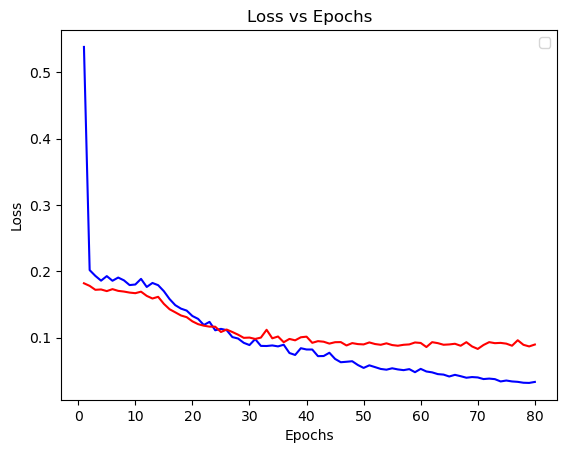

In [14]:
# Drawing the Training Loss vs Epochs
graph_plot("Loss vs Epochs", "Epochs", "Loss", list(loss_dic.keys()), list(loss_dic.values()), list(valid_loss_dic.values()))

In [15]:
# Saving the model
torch.save(model.state_dict(), model_name)

# Testing the Model

In [16]:
# Testing the model, and evaluating the f1 score
test_file = '../../Data/NCBItestset_corpus.txt'
test_lines = read_dataset(test_file)
test_paragraphs = parse_dataset(test_lines)

In [17]:
# Parsing and storing the test dataset
test_sentences = []
test_tags = []

for paragraph in test_paragraphs:
    sentences, annotations = parse_paragraph(paragraph)
    tagged_sentences = tag_annotations(sentences, annotations)
    for sentence, tags in tagged_sentences:
        test_sentences.append(sentence)
        test_tags.append(tags)

In [18]:
# Importing the model file
model = BiLSTM_CrossAttention_NER_Model(len(word_encoder), len(tag_encoder.classes_)).to(device)
model.load_state_dict(torch.load(model_name))
model.eval()

BiLSTM_CrossAttention_NER_Model(
  (embedding): Embedding(14805, 128)
  (batch_norm_emb): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bilstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.35, bidirectional=True)
  (cross_attention): CrossAttention(
    (query): Linear(in_features=256, out_features=256, bias=False)
    (key): Linear(in_features=256, out_features=256, bias=False)
    (value): Linear(in_features=256, out_features=256, bias=False)
    (softmax): Softmax(dim=-1)
  )
  (batch_norm_att): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.35, inplace=False)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

In [19]:
# Prepare the test data
test_dataset = LSTM_Attention_NERDataset(test_sentences, test_tags, word_encoder, tag_encoder, '<UNK>')
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: x)

# Display the counts and tags of <UNK> tokens
print(f"Number of <UNK> tokens in the testing dataset: {test_dataset.unk_count}")
print(f"Tags of <UNK> tokens in the testing dataset: {Counter(test_dataset.unk_tags)}")

# Evaluate the model
all_true_labels = []
all_pred_labels = []

result = "../../Result/TestResults_CrossAttention_BiLSTM_NER.txt"
with open(result, 'w') as t_file:
    with torch.no_grad():
        for batch in test_dataloader:
            sentences, tags = zip(*batch)
            sentences = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True).to(device)
            tags = torch.nn.utils.rnn.pad_sequence(tags, batch_first=True, padding_value=-100).to(device)

            outputs = model(sentences)
            outputs = outputs.view(-1, outputs.shape[-1])
            tags = tags.view(-1)

            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
            true_labels = tags.cpu().numpy()

            mask = true_labels != -100
            pred_labels = predictions[mask]
            true_labels = true_labels[mask]

            pred_labels_decoded = tag_encoder.inverse_transform(pred_labels)
            true_labels_decoded = tag_encoder.inverse_transform(true_labels)

            for true_label, pred_label in zip(true_labels_decoded, pred_labels_decoded):
                t_file.write(f'True: {true_label}, Pred: {pred_label}\n')
                all_true_labels.append(true_label)
                all_pred_labels.append(pred_label)

# Printing classification report
report = classification_report(all_true_labels, all_pred_labels)
print (report)

Number of <UNK> tokens in the testing dataset: 0
Tags of <UNK> tokens in the testing dataset: Counter()
                    precision    recall  f1-score   support

I-CompositeMention       0.56      0.36      0.44        89
    I-DiseaseClass       0.70      0.25      0.37       255
 I-SpecificDisease       0.75      0.74      0.74      1457
                 O       0.97      0.99      0.98     18601

          accuracy                           0.96     20402
         macro avg       0.75      0.58      0.63     20402
      weighted avg       0.95      0.96      0.95     20402



In [20]:
'''
Testing the G_Mean based on the heatmap of Confusion Matrix
'''
precision = precision_score(all_true_labels, all_pred_labels, average = None)
recall = recall_score(all_true_labels, all_pred_labels, average = None)
print(precision)
print(recall)
g_mean = []
G_Mean = 0
for p, r in zip(precision, recall):
    class_gmean = sqrt(p*r)
    g_mean.append(class_gmean)
    G_Mean += class_gmean

G_Mean /= len(precision)
print (G_Mean)
print(g_mean)



[0.56140351 0.7        0.75034868 0.97460284]
[0.35955056 0.24705882 0.73850377 0.98612978]
0.6474736192371187
[0.4492804769564075, 0.4158619680502032, 0.744402665893516, 0.980349366048348]


## Calculating the overall accuracy of the model

In [21]:
file_path = "../../Result/TestResults_CrossAttention_BiLSTM_NER.txt"

true_tags = []
pred_tags = []

with open(file_path, "r") as res_file:
    for line in res_file:
        if 'True:' in line and 'Pred:' in line:
            parts = line.split(', ')
            true_la = parts[0].split(': ')[1]
            pred_la = parts[1].split(': ')[1]

            true_tags.append(true_la)
            pred_tags.append(pred_la)

labels = sorted(list(set(true_tags) | set(pred_tags)))
c_mat = confusion_matrix(true_tags, pred_tags, labels=labels)
print(c_mat)

[[    0    32     0     0     0    27     0    30]
 [    0     0     0     0     0     0     0     0]
 [    0     4     0    63     0    98     0    90]
 [    0     0     0     0     0     0     0     0]
 [    0    13     0    10     0  1076     0   358]
 [    0     0     0     0     0     0     0     0]
 [    0     8     0    17     0   233     0 18343]
 [    0     0     0     0     0     0     0     0]]


### Normalize the Confusion Matrix

In [22]:
c_mat_norm = c_mat.astype('float') / c_mat.sum(axis = 1)[: , np.newaxis]
c_mat_norm

C:\Users\Adit\AppData\Local\Temp\ipykernel_14000\2569737847.py:1: RuntimeWarning: invalid value encountered in divide
  c_mat_norm = c_mat.astype('float') / c_mat.sum(axis = 1)[: , np.newaxis]


array([[0.00000000e+00, 3.59550562e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.03370787e-01, 0.00000000e+00, 3.37078652e-01],
       [           nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan],
       [0.00000000e+00, 1.56862745e-02, 0.00000000e+00, 2.47058824e-01,
        0.00000000e+00, 3.84313725e-01, 0.00000000e+00, 3.52941176e-01],
       [           nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan],
       [0.00000000e+00, 8.92244338e-03, 0.00000000e+00, 6.86341798e-03,
        0.00000000e+00, 7.38503775e-01, 0.00000000e+00, 2.45710364e-01],
       [           nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan],
       [0.00000000e+00, 4.30084404e-04, 0.00000000e+00, 9.13929359e-04,
        0.00000000e+00, 1.25262083e-02, 0.00000000e+00, 9.

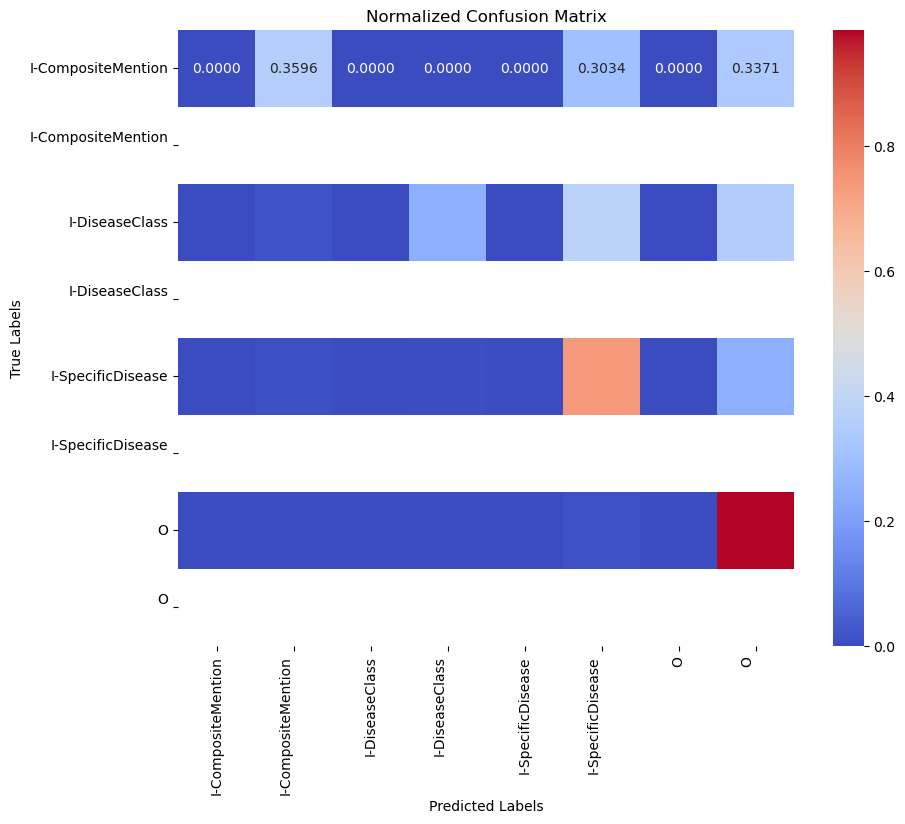

In [23]:
# Create a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(c_mat_norm, annot=True, fmt=".4f", xticklabels=labels, yticklabels=labels, cmap='coolwarm', square=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title("Normalized Confusion Matrix")
plt.show()